Jorge Martinez Gil, 100508957

Dataset

In [4]:
import pandas as pd

DATA_PATH = "../march-machine-learning-mania-2024/"

class NCAADataset():
    def __init__(self):
        # Teams
        self.teams = pd.read_csv(DATA_PATH + "MTeams.csv")

        # Seeds
        self.seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
        #print(self.seeds.head())

        # Regular Season Data
        self.season_results = self._prepare_data(DATA_PATH + "MRegularSeasonDetailedResults.csv")
        #print(self.season_results.columns)
        #print(self.season_results.head())
        #print(self.season_results.shape)

        # Tournament Data
        self.tournament_results = self._prepare_data(DATA_PATH + "MNCAATourneyDetailedResults.csv")
        #print(self.tournament_results.head())
        #print(self.tournament_results.shape)


        # Feature Engineering
        self.tournament_data = self._feature_engineering(self.season_results, self.tournament_results, self.seeds)

        # 2024 Tournament Games
        self.tournament_2024 = pd.read_csv(DATA_PATH + "2024_tourney_seeds.csv")


    def expand_matchup(self, matchup):
        matchup = pd.merge(matchup, self.season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        matchup = pd.merge(matchup, self.season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

        matchup = pd.merge(matchup, self.seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        matchup = pd.merge(matchup, self.seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

        # Add last 14 days
        #matchup = pd.merge(matchup, self.last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        #matchup = pd.merge(matchup, self.last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

        matchup["Seed_diff"] = matchup["T1_seed"] - matchup["T2_seed"]

        return matchup
        

    def _prepare_data(self, path):
        season_results = pd.read_csv(path)
        
        # Swap contains the same data as season_results, but with the winning and losing teams swapped
        season_results_swap = season_results.copy()

        season_results_swap.loc[season_results['WLoc'] == 'H', 'WLoc'] = 'A'
        season_results_swap.loc[season_results['WLoc'] == 'A', 'WLoc'] = 'H'
        season_results.columns.values[6] = 'location'
        season_results_swap.columns.values[6] = 'location'

        season_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(season_results.columns)]
        season_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(season_results_swap.columns)]

        # Order columns to follow same structure
        season_results_swap = season_results_swap[season_results.columns]


        # Mix them together
        season_results = pd.concat([season_results, season_results_swap]).sort_index().reset_index(drop = True)

        season_results.loc[season_results.location=='N','location'] = '0'
        season_results.loc[season_results.location=='H','location'] = '1'
        season_results.loc[season_results.location=='A','location'] = '-1'
        season_results.location = season_results.location.astype(int)

        season_results['PointDiff'] = season_results['T1_Score'] - season_results['T2_Score']

        #print(season_results.head())

        #season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(np.mean)
        #season_statistics.head()

        return season_results
    

    def _feature_engineering(self, season_results, tournament_results, seeds):
        # Group each team stats by season
        team_prefixes = ['T1_', 'T2_']
        metrics = ['FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']
        boxscore_cols = [f"{prefix}{metric}" for prefix in team_prefixes for metric in metrics] + ['PointDiff']

        season_statistics = season_results.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg('mean').reset_index()


        # Duplicate season_statistics for T1 and T2
        season_statistics_T1 = season_statistics.copy()
        season_statistics_T2 = season_statistics.copy()

        season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
        season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
        season_statistics_T1.columns.values[0] = "Season"
        season_statistics_T2.columns.values[0] = "Season"


        # Add season statistics to tournament games
        tournament_results = tournament_results[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]# TODO POdemos utilizar T2Score y T1Score????

        tournament_results = pd.merge(tournament_results, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        tournament_results = pd.merge(tournament_results, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')


        
        # Add last 14 days
        """
        #print("Adding last 14 days stats")
        last14days_stats_T1 = season_results.loc[season_results.DayNum>118].reset_index(drop=True)
        last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
        last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

        last14days_stats_T2 = season_results.loc[season_results.DayNum>118].reset_index(drop=True)
        last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
        last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

        tournament_results = pd.merge(tournament_results, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        tournament_results = pd.merge(tournament_results, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        self.last14days_stats_T1 = last14days_stats_T1
        self.last14days_stats_T2 = last14days_stats_T2
        """
        

        # Add team quality

        # Add seed difference
        seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

        seeds_T1 = seeds[['Season','TeamID','seed']].copy()
        seeds_T2 = seeds[['Season','TeamID','seed']].copy()
        seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
        seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

        tournament_results = pd.merge(tournament_results, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        tournament_results = pd.merge(tournament_results, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

        tournament_results["Seed_diff"] = tournament_results["T1_seed"] - tournament_results["T2_seed"]


        # To use it for the 2024 playoffs
        self.seeds_T1 = seeds_T1
        self.seeds_T2 = seeds_T2
        self.season_statistics_T1 = season_statistics_T1
        self.season_statistics_T2 = season_statistics_T2

        return tournament_results
    



In [5]:
dataset = NCAADataset()

# Data
print("### DATA ###")
print(dataset.tournament_data.head())
print(dataset.tournament_data.tail())
print(dataset.tournament_data.shape)
#print(dataset.tournament_data.columns)

### DATA ###
   Season  DayNum  T1_TeamID  T1_Score  T2_TeamID  T2_Score     T1_FGM  \
0    2003     134       1421        92       1411        84  24.379310   
1    2003     134       1411        84       1421        92  24.733333   
2    2003     136       1436        51       1112        80  24.827586   
3    2003     136       1112        80       1436        51  30.321429   
4    2003     136       1113        84       1272        71  27.206897   

      T1_FGA   T1_FGM3    T1_FGA3  ...  T2_opponent_DR  T2_opponent_Ast  \
0  56.793103  6.482759  18.000000  ...       22.866667        13.766667   
1  55.266667  5.933333  18.500000  ...       22.827586        15.862069   
2  55.862069  5.275862  15.482759  ...       23.285714        15.464286   
3  65.714286  7.035714  20.071429  ...       21.862069        13.275862   
4  56.896552  4.000000  12.586207  ...       23.586207        13.310345   

   T2_opponent_TO  T2_opponent_Stl  T2_opponent_Blk  T2_opponent_PF  \
0       14.333333   

XGBoost

In [6]:
import xgboost
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


class XGBPredictor:
    def __init__(self, data):
        self.data = data
        self.y = data['T1_Score'] - data['T2_Score']
        #y = np.where(y > 0, 1, 0)
        print("Target: ")
        print(self.y.head())
        print(self.y.shape)

        self.X = data[data.columns[6:]]
        print("Features: ")
        print(self.X.head())
        print("Shape of X: " + str(self.X.shape))

        self.param = {
            'eval_metric': 'mae',
            'booster': 'gbtree',
            'eta': 0.05,
            'subsample': 0.35,
            'colsample_bytree': 0.7,
            'num_parallel_tree': 3,
            'min_child_weight': 40,
            'gamma': 10,
            'max_depth': 3,
            'verbosity': 0
        }
        self.repeat_cv = 3

    def cauchyobj(self, preds, dtrain):
        labels = dtrain.get_label()
        c = 5000
        x = preds - labels
        grad = x / (x**2/c**2+1)
        hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
        return grad, hess

    def train_model(self):
        X = self.X
        y = self.y

        dtrain = xgboost.DMatrix(X.values, label=y)
        xgb_cv = []

        for i in range(self.repeat_cv):
            print(f"Fold repeater {i}")
            xgb_cv.append(
                xgboost.cv(
                    params=self.param,
                    dtrain=dtrain,
                    obj=self.cauchyobj,
                    num_boost_round=3000,
                    folds=KFold(n_splits=5, shuffle=True, random_state=i),
                    early_stopping_rounds=25,
                    verbose_eval=50
                )
            )

        # print("Cross-validation results: " + str(xgb_cv))
        self.iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
        print("Repeat CV result: ", self.iteration_counts)
        val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
        print("Validation MAE: ", val_mae)
        self.dtrain = dtrain
        #print(xgb_cv)

        # out-of-fold prediction
        oof_preds = []
        for i in range(self.repeat_cv):
            print(f"Fold repeater {i}")
            preds = y.copy()
            preds = preds.astype(float)
            kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
            for train_index, val_index in kfold.split(X,y):
                dtrain_i = xgboost.DMatrix(X.iloc[train_index], label = y.iloc[train_index])
                dval_i = xgboost.DMatrix(X.iloc[val_index], label = y.iloc[val_index])  
                model = xgboost.train(
                    params = self.param,
                    dtrain = dtrain_i,
                    num_boost_round = self.iteration_counts[i],
                    verbose_eval = 50
                )
                preds[val_index] = model.predict(dval_i)
            oof_preds.append(np.clip(preds,-30,30))


        # Plotting the out-of-fold predictions
        plot_df = pd.DataFrame({"pred": oof_preds[0], "label": np.where(y > 0, 1, 0)})
        plot_df["pred_int"] = plot_df["pred"].astype(int)
        plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

        plt.figure()
        plt.plot(plot_df.pred_int, plot_df.average_win_pct)
        #plt.savefig('img/out-of-fold.png')
        plt.show()


        # Spline interpolation
        val_cv = []
        spline_model = []

        for i in range(self.repeat_cv):
            dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
            dat = sorted(dat, key = lambda x: x[0])
            datdict = {}
            for k in range(len(dat)):
                datdict[dat[k][0]]= dat[k][1]
            spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
            spline_fit = spline_model[i](oof_preds[i])
            spline_fit = np.clip(spline_fit,0.025,0.975)

            
            spline_fit[(self.data.T1_seed==1) & (self.data.T2_seed==16) & (self.data.T1_Score > self.data.T2_Score)] = 1.0
            spline_fit[(self.data.T1_seed==2) & (self.data.T2_seed==15) & (self.data.T1_Score > self.data.T2_Score)] = 1.0
            spline_fit[(self.data.T1_seed==3) & (self.data.T2_seed==14) & (self.data.T1_Score > self.data.T2_Score)] = 1.0
            spline_fit[(self.data.T1_seed==4) & (self.data.T2_seed==13) & (self.data.T1_Score > self.data.T2_Score)] = 1.0
            spline_fit[(self.data.T1_seed==16) & (self.data.T2_seed==1) & (self.data.T1_Score < self.data.T2_Score)] = 0.0
            spline_fit[(self.data.T1_seed==15) & (self.data.T2_seed==2) & (self.data.T1_Score < self.data.T2_Score)] = 0.0
            spline_fit[(self.data.T1_seed==14) & (self.data.T2_seed==3) & (self.data.T1_Score < self.data.T2_Score)] = 0.0
            spline_fit[(self.data.T1_seed==13) & (self.data.T2_seed==4) & (self.data.T1_Score < self.data.T2_Score)] = 0.0
            

            val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":self.data.Season}))
            print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

        val_cv = pd.concat(val_cv)
        val_cv = val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))
        print(val_cv)
    

        plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
        plot_df["pred_int"] = (plot_df["pred"]).astype(int)
        plot_df = plot_df.groupby('pred_int')[['spline', 'label']].mean().reset_index()

        plt.figure()
        plt.plot(plot_df.pred_int,plot_df.spline)
        plt.plot(plot_df.pred_int,plot_df.label)
        #plt.savefig('img/spline.png')
        plt.show()


        # Train final model on the entire dataset
        #num_boost_round = int(np.mean(self.iteration_counts))
        #print(f"num_boost_rounds={num_boost_round}")
        #self.final_model = xgb.train(params=self.param, dtrain=dtrain, num_boost_round=num_boost_round)
        sub_models = []
        for i in range(self.repeat_cv):
            print(f"Fold repeater {i}")
            sub_models.append(
                xgboost.train(
                params = self.param,
                dtrain = dtrain,
                num_boost_round = int(self.iteration_counts[i] * 1.05),
                verbose_eval = 50
                )
            )

        self.sub_models = sub_models
        self.spline_model = spline_model

        


    def predict_matchup(self, matchup):
        dtest = xgboost.DMatrix(matchup.values)
        """
        sub_preds = []
        for model in self.final_model:
            sub_preds.append(model.predict(dtest))
        """
        sub_preds = []
        for i in range(self.repeat_cv):
            sub_preds.append(np.clip(self.spline_model[i](np.clip(self.sub_models[i].predict(dtest),-30,30)),0.025,0.975))

        if pd.DataFrame(sub_preds).mean(axis=0).item() > 0.5:
            return True
        else:
            return False
        #sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
        #sub[['ID', 'Pred']].to_csv("submission.csv", index=None)


### TRAINING MODEL ###
Target: 
0     8
1    -8
2   -29
3    29
4    13
dtype: int64
(2630,)
Features: 
      T1_FGM     T1_FGA   T1_FGM3    T1_FGA3     T1_FTM     T1_FTA      T1_OR  \
0  24.379310  56.793103  6.482759  18.000000  15.965517  20.931034  12.275862   
1  24.733333  55.266667  5.933333  18.500000  17.400000  28.066667  13.166667   
2  24.827586  55.862069  5.275862  15.482759  12.862069  19.551724  12.965517   
3  30.321429  65.714286  7.035714  20.071429  17.535714  25.000000  15.178571   
4  27.206897  56.896552  4.000000  12.586207  17.551724  26.206897  13.689655   

       T1_DR     T1_Ast      T1_TO  ...  T2_opponent_DR  T2_opponent_Ast  \
0  23.172414  13.034483  16.206897  ...       22.866667        13.766667   
1  24.800000  14.200000  15.233333  ...       22.827586        15.862069   
2  25.724138  14.206897  14.068966  ...       23.285714        15.464286   
3  27.642857  17.642857  14.785714  ...       21.862069        13.275862   
4  23.310345  15.551724  14.0

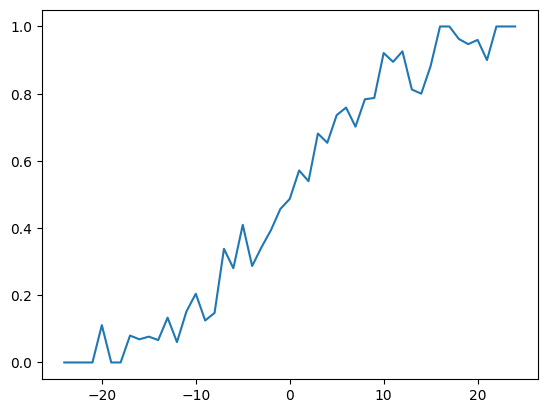

adjusted logloss of cvsplit 0: 0.5318912956329822
adjusted logloss of cvsplit 1: 0.5316056931215835
adjusted logloss of cvsplit 2: 0.5306631444768599
season
2003    0.516914
2004    0.494575
2005    0.472573
2006    0.528037
2007    0.422747
2008    0.461141
2009    0.474632
2010    0.546291
2011    0.579826
2012    0.555434
2013    0.588209
2014    0.567107
2015    0.502188
2016    0.551625
2017    0.483643
2018    0.587167
2019    0.482147
2021    0.575284
2022    0.637760
2023    0.586124
dtype: float64


C:\Users\jorge\AppData\Local\Temp\ipykernel_4280\2700536621.py:135: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_cv = val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))


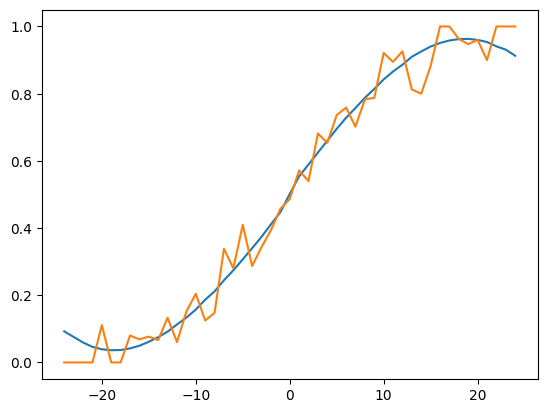

Fold repeater 0
Fold repeater 1
Fold repeater 2


In [7]:
print("### TRAINING MODEL ###")

xgb = XGBPredictor(dataset.tournament_data)

xgb.train_model()

Neural Network

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


class NNPredictor(nn.Module):
    def __init__(self, data):
        self.scaler = StandardScaler()
        self.batch_size = 32
        self.epochs = 20

        self.train_loader, self.test_loader = self._load_and_prepare_data(data)

        print(self.train_loader.dataset.tensors[0].shape[1])

        ### Neural Network
        super(NNPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(self.train_loader.dataset.tensors[0].shape[1], 32),#64, 512
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )


    def _load_and_prepare_data(self, data):
        y = (data['T1_Score'] > data['T2_Score']).astype(int)
        X = data[data.columns[6:]]


        print("Target: ")
        print(y.head())
        print("Shape of y: " + str(y.shape))

        print("Features: ")
        print(X.head())
        print("Shape of X: " + str(X.shape))

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

        # Normalize the features
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)

        # Convert to tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

        # Datasets and Loaders
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True), DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)


    def forward(self, x):
        return self.model(x)


    def train_model(self):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=0.03)

        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []

        train_precisions = []
        train_recalls = []
        test_precisions = []
        test_recalls = []


        # Early stopping
        best_val_loss = float('inf')
        early_stop_counter = 0
        patience = 3

        # Learning Rate Scheduling
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        # Training
        for epoch in range(self.epochs):
            self.model.train()
            train_loss, correct, total, tp, fp, fn = 0, 0, 0, 0, 0, 0

            for inputs, labels in self.train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Sum up batch loss
                train_loss += loss.item() * inputs.size(0)
                # Calculate accuracy
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                tp += ((predicted == 1) & (labels == 1)).sum().item()
                fp += ((predicted == 1) & (labels == 0)).sum().item()
                fn += ((predicted == 0) & (labels == 1)).sum().item()
            
            # Calculate metrics
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            train_losses.append(train_loss / len(self.train_loader.dataset))
            train_accuracies.append(100 * correct / total)
            train_precisions.append(precision)
            train_recalls.append(recall)

            # Evaluation
            self.model.eval()
            test_loss, correct, total, tp, fp, fn = 0, 0, 0, 0, 0, 0
            with torch.no_grad():
                for inputs, labels in self.test_loader:
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * inputs.size(0)
                    predicted = (outputs > 0.5).float()
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                    tp += ((predicted == 1) & (labels == 1)).sum().item()
                    fp += ((predicted == 1) & (labels == 0)).sum().item()
                    fn += ((predicted == 0) & (labels == 1)).sum().item()

            # Calculate metrics for test
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            test_losses.append(test_loss / len(self.test_loader.dataset))
            test_accuracies.append(100 * correct / total)
            test_precisions.append(precision)
            test_recalls.append(recall)
            # TODO: Que hacer con precision y recall??

            # Early stopping
            if test_losses[-1] < best_val_loss:
                best_val_loss = test_losses[-1]
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            
            if early_stop_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break


            # Learning Rate Scheduling
            scheduler.step()


            #if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}%, '
                f'Val Loss: {test_losses[-1]}, Val Accuracy: {test_accuracies[-1]}%')


        self._plot_training(train_losses, test_losses, train_accuracies, test_accuracies)
        
    def _plot_training(self, train_losses, test_losses, train_accuracies, test_accuracies):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(test_accuracies, label='Validation Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        #plt.savefig('img/train_val_loss_acc.png')
        plt.show()


    def predict_matchup(self, matchup):
        """
        Predict outcome of a game between two teams.

        Parameters:
        matchup

        Returns:
        bool: Predicts Team1 wins the game.
        """
        #print(matchup.shape)
        # Extract features and apply the same preprocessing as training data
        features = self.scaler.transform(matchup.values)  # Apply scaling

        # Convert to tensor
        features_tensor = torch.tensor(features, dtype=torch.float32)

        # Model prediction
        self.model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            output = self(features_tensor)
            predicted_probability = output.item()  # get the scalar value of the tensor

        print(predicted_probability)
        return predicted_probability >= 0.5
    
    def __str__(self):
        # Initialize an empty string to store the network structure
        network_str = ""
        
        # Iterate through the layers of the model
        for i, layer in enumerate(self.model):
            # Add the layer type and its parameters to the string
            network_str += f"Layer {i+1}: {layer.__class__.__name__}"
            # Add the number of input and output features if applicable
            if hasattr(layer, "in_features"):
                network_str += f" (Input: {layer.in_features}, Output: {layer.out_features})"
            network_str += "\n"
        
        return network_str

Target: 
0    1
1    0
2    0
3    1
4    1
dtype: int32
Shape of y: (2630,)
Features: 
      T1_FGM     T1_FGA   T1_FGM3    T1_FGA3     T1_FTM     T1_FTA      T1_OR  \
0  24.379310  56.793103  6.482759  18.000000  15.965517  20.931034  12.275862   
1  24.733333  55.266667  5.933333  18.500000  17.400000  28.066667  13.166667   
2  24.827586  55.862069  5.275862  15.482759  12.862069  19.551724  12.965517   
3  30.321429  65.714286  7.035714  20.071429  17.535714  25.000000  15.178571   
4  27.206897  56.896552  4.000000  12.586207  17.551724  26.206897  13.689655   

       T1_DR     T1_Ast      T1_TO  ...  T2_opponent_DR  T2_opponent_Ast  \
0  23.172414  13.034483  16.206897  ...       22.866667        13.766667   
1  24.800000  14.200000  15.233333  ...       22.827586        15.862069   
2  25.724138  14.206897  14.068966  ...       23.285714        15.464286   
3  27.642857  17.642857  14.785714  ...       21.862069        13.275862   
4  23.310345  15.551724  14.000000  ...      

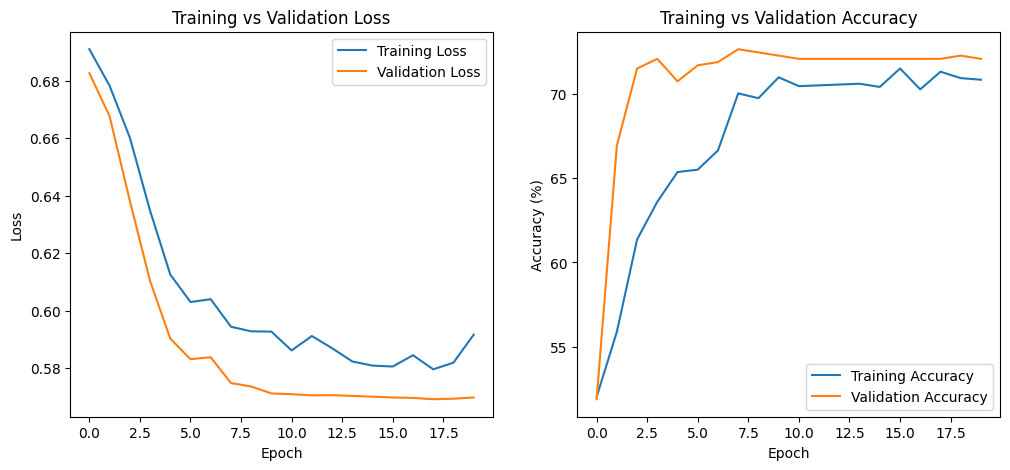

Sequential(
  (0): Linear(in_features=57, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.6, inplace=False)
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.6, inplace=False)
  (6): Linear(in_features=16, out_features=1, bias=True)
  (7): Sigmoid()
)


In [26]:
n_n = NNPredictor(dataset.tournament_data)

n_n.train_model()

print(n_n.model)

Evaluate

In [27]:
import pandas as pd
import numpy as np


def evaluate(results):
    num_games = results['Wins'].sum()
    print(f"Number of games: {num_games}")#63

    assert results['Wins'].sum() == results['PredictedWins'].sum()
    
    print(results.head())
    """
        TeamID      TeamName  PredictedWins  Wins
    0    1163   Connecticut     6              6
    1    1235       Iowa St     2              1
    2    1228      Illinois     3              3
    3    1120        Auburn     0              2
    4    1361  San Diego St     2              1
    """
    results['Diff'] = results['PredictedWins'] - results['Wins']
    results['AbsDiff'] = results['Diff'].abs()
    errors = results['AbsDiff'].sum()
    print(f"Errors: {errors}")#90

    results['Accuracy'] = np.where(results['Diff'] <= 0, 
                             results['PredictedWins'], 
                             results['Wins'])

    accuracy = results['Accuracy'].sum() / num_games

    results['Points'] = results['Accuracy'].apply(lambda x: 10 * 2 ** (x - 1) if x != 0 else 0)
    
    points = results['Points'].sum()
    
    return accuracy, points


def compare_bracket(predictions):
    actual_results = pd.read_csv("../predictions/results.csv")

    predictions_df = pd.DataFrame(list(predictions.items()), columns=['TeamID', 'PredictedWins'])

    # Merge with the actual wins DataFrame
    merged_df = actual_results.merge(predictions_df, on='TeamID')

    accuracy, points = evaluate(merged_df)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Points: {points}")

    # Compare against analyst
    pro_pred = ["../predictions/stephen_a.csv", "../predictions/shae_cornette.csv"]
    for pred_file in pro_pred:
        pro_pred_df = pd.read_csv(pred_file)
        pro_pred_df.rename(columns={'Wins': 'PredictedWins'}, inplace=True)
        pro_pred_df = pro_pred_df.merge(actual_results, on=['TeamID', 'TeamName'])

        accuracy, points = evaluate(pro_pred_df)
        print(f"Accuracy for {pred_file}: {accuracy:.2f}")
        print(f"Points for {pred_file}: {points}")
        

In [28]:

import pandas as pd


def create_matchups(df):
    # Specifying the order for a playoff structure
    order = [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15]

    # Adjusting the order (subtracting 1 for zero-based indexing)
    ordered_df = df.iloc[[o-1 for o in order]].reset_index(drop=True)

    return ordered_df


def simulate_matchups(df, expand_matchup, predict_matchup, predictions):
    #print(df.head())
    winners = []
    for i in range(0, len(df), 2):
        team1 = df.iloc[i]
        team2 = df.iloc[i+1]

        print(f"Matchup {i//2 + 1}: {team1['TeamName']} vs {team2['TeamName']}")

        # Prepare data to make prediction
        merged_df = pd.DataFrame(columns=['T1_TeamID', 'T2_TeamID'])
        new_row = pd.DataFrame({'T1_TeamID': [team1['TeamID']], 'T2_TeamID': [team2['TeamID']], 'Season': [2024]})
        merged_df = pd.concat([merged_df, new_row], ignore_index=True)
        merged_df = expand_matchup(merged_df)
        merged_df = merged_df.drop(columns=['T1_TeamID', 'T2_TeamID', 'Season'])
        #print(merged_df.head())
        #print(merged_df.shape)
        
        # Predict winner
        winner = predict_matchup(merged_df)
        if winner:
            winner_team = team1
            loser_team = team2
        else:
            winner_team = team2
            loser_team = team1

        # Increment win count in predictions
        predictions[winner_team['TeamID']] = predictions.get(winner_team['TeamID'], 0) + 1
        predictions[loser_team['TeamID']] = predictions.get(loser_team['TeamID'], 0)

        winners.append(winner_team)
        print(f"Winner: {winners[-1]['TeamName']}\n")

    winners_df = pd.DataFrame(winners).reset_index(drop=True)
    return winners_df


def simulate_bracket(bracket_data, expand_matchup, predict_matchup, predictions):
    # W/X/Y/Z are East,Midwest,South,West. TODO Ojo con esto, creo que esta mal

    # Order vector so that it follows the bracket structure
    matchups_w = create_matchups(bracket_data[bracket_data['Seed'].str.startswith('W')].sort_values(by='Seed'))
    matchups_x = create_matchups(bracket_data[bracket_data['Seed'].str.startswith('X')].sort_values(by='Seed'))
    matchups_y = create_matchups(bracket_data[bracket_data['Seed'].str.startswith('Y')].sort_values(by='Seed'))
    matchups_z = create_matchups(bracket_data[bracket_data['Seed'].str.startswith('Z')].sort_values(by='Seed'))
    

    print("### First round ###\n")
    print("# East #")
    matchups_w = simulate_matchups(matchups_w, expand_matchup, predict_matchup, predictions)
    print("# West #")
    matchups_x = simulate_matchups(matchups_x, expand_matchup, predict_matchup, predictions)
    print("# South #")
    matchups_z = simulate_matchups(matchups_z, expand_matchup, predict_matchup, predictions)
    print("# Midwest #")
    matchups_y = simulate_matchups(matchups_y, expand_matchup, predict_matchup, predictions)
    
    
    print("### Second round ###")
    print("# East #")
    matchups_w = simulate_matchups(matchups_w, expand_matchup, predict_matchup, predictions)
    print("# West #")
    matchups_x = simulate_matchups(matchups_x, expand_matchup, predict_matchup, predictions)
    print("# South #")
    matchups_z = simulate_matchups(matchups_z, expand_matchup, predict_matchup, predictions)
    print("# Midwest #")
    matchups_y = simulate_matchups(matchups_y, expand_matchup, predict_matchup, predictions)
    
    print("### Sweet 16 ###")
    print("# East #")
    matchups_w = simulate_matchups(matchups_w, expand_matchup, predict_matchup, predictions)
    print("# West #")
    matchups_x = simulate_matchups(matchups_x, expand_matchup, predict_matchup, predictions)
    print("# South #")
    matchups_z = simulate_matchups(matchups_z, expand_matchup, predict_matchup, predictions)
    print("# Midwest #")
    matchups_y = simulate_matchups(matchups_y, expand_matchup, predict_matchup, predictions)
    

    print("### Elite 8 ###")
    print("# East #")
    winner_w = simulate_matchups(matchups_w, expand_matchup, predict_matchup, predictions)
    print("# West #")
    winner_x = simulate_matchups(matchups_x, expand_matchup, predict_matchup, predictions)
    print("# South #")
    winner_z = simulate_matchups(matchups_z, expand_matchup, predict_matchup, predictions)
    print("# Midwest #")
    winner_y = simulate_matchups(matchups_y, expand_matchup, predict_matchup, predictions)
    

    print("### Final Four ###")
    matchups = pd.concat([winner_w, winner_x, winner_z, winner_y], ignore_index=True)
    matchups = simulate_matchups(matchups, expand_matchup, predict_matchup, predictions)

    print("### Championship ###")
    winner = simulate_matchups(matchups, expand_matchup, predict_matchup, predictions)


    print("### Champion ###")
    print(winner['TeamName'].values[0])

    

In [31]:

# Simulate 2024 bracket
print("### 2024 BRACKET ###")
bracket_data = dataset.tournament_2024[dataset.tournament_2024['Tournament'] == 'M']
bracket_data = bracket_data.merge(dataset.teams, on='TeamID', how='inner')
bracket_data = bracket_data[['Seed', 'TeamName', 'TeamID']]
#print(bracket_data.head())


predictions = {}
match_predictor = n_n.predict_matchup
simulate_bracket(bracket_data, dataset.expand_matchup, match_predictor, predictions)

# Evaluate predictions with the actual results
compare_bracket(predictions)


### 2024 BRACKET ###
### First round ###

# East #
Matchup 1: Connecticut vs Stetson
0.8119325041770935
Winner: Connecticut

Matchup 2: FL Atlantic vs Northwestern
0.5608252286911011
Winner: FL Atlantic

Matchup 3: San Diego St vs UAB
0.6283463835716248
Winner: San Diego St

Matchup 4: Auburn vs Yale
0.6741285920143127
Winner: Auburn

Matchup 5: BYU vs Duquesne
0.6586354970932007
Winner: BYU

Matchup 6: Illinois vs Morehead St
0.6697424054145813
Winner: Illinois

Matchup 7: Washington St vs Drake
0.5868790149688721
Winner: Washington St

Matchup 8: Iowa St vs S Dakota St
0.7437994480133057
Winner: Iowa St

# West #
Matchup 1: North Carolina vs Howard
0.7708067893981934
Winner: North Carolina

Matchup 2: Mississippi St vs Michigan St
0.49151137471199036
Winner: Michigan St

Matchup 3: St Mary's CA vs Grand Canyon
0.7117786407470703
Winner: St Mary's CA

Matchup 4: Alabama vs Col Charleston
0.6453532576560974
Winner: Alabama

Matchup 5: Clemson vs New Mexico
0.4660975933074951
Winner: Ne